# 3D U-Net variantes: encoders ResNet50 & VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-3D

Make sure TensorFlow == 2.8, Keras == 2.8

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [4]:
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import segmentation_models_3D as sm
from tensorflow.keras.callbacks import Callback

Segmentation Models: using `tf.keras` framework.


In [18]:
train_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_original2.npy')
train_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_mask2.npy')
validation_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_original2.npy')
validation_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_mask2.npy')
#test_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_original9.npy')
#test_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_mask9.npy')

In [ ]:
print("Dimension of the 3D original image:", train_original_3D.shape)
print("Dimension of the 3D mask image:", validation_mask_3D.shape)

Dimension of the 3D original image: (112, 128, 128, 64, 3)
Dimension of the 3D mask image: (16, 128, 128, 64, 2)


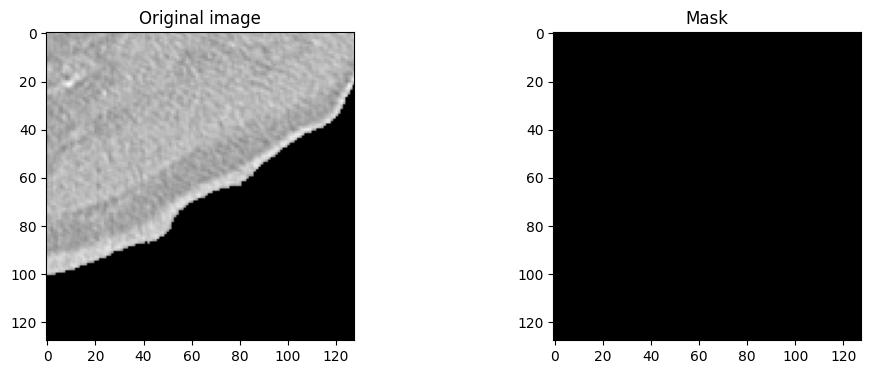

In [ ]:
# Check the patches
# Change the patch and slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_3D[110,:,:,25,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_3D[110,:,:,25,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [14]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [15]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

In [16]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [17]:
# Backbone setting and preprocessing
backbone = 'vgg16' #resnet50, vgg16
preprocess_input = sm.get_preprocessing(backbone)

In [19]:
# Normalisation of the images
train_original_3D = preprocess_input(train_original_3D)
validation_original_3D = preprocess_input(validation_original_3D)
#test_original_3D = preprocess_input(test_original_3D)

In [20]:
# Define the model
model = sm.Unet(backbone, classes=2,
                input_shape=(128, 128, 64, 3),
                encoder_weights='imagenet',
                activation='sigmoid')

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

176619520/176606448 [==============================] - 10s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 block1_conv1 (Conv3D)          (None, 128, 128, 64  5248        ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 block1_conv2 (Conv3D)          (None, 128, 128, 64  110656      ['block1_conv1[0][0]']           
                        

In [ ]:
# Save the output of every epoch
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,43,0], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,43,0], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,43,0], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir_resn = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/resnet50'
save_dir_vgg = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/vgg16'
os.makedirs(save_dir_vgg, exist_ok=True) # save_dir_vgg, save_dir_resn

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_3D, validation_mask_3D),
                                                    save_dir=save_dir_vgg) # save_dir_vgg, save_dir_resn

In [21]:
history=model.fit(train_original_3D,
          train_mask_3D,
          batch_size=16,
          epochs=60,
          verbose=1,
          validation_data=(validation_original_3D, validation_mask_3D))
          #callbacks=[save_predictions_callback])

Epoch 1/60
28/28 [==============================] - 21s 414ms/step - loss: 0.5495 - iou_score: 0.4655 - f1-score: 0.5829 - val_loss: 0.6833 - val_iou_score: 0.2866 - val_f1-score: 0.4052
Epoch 2/60
28/28 [==============================] - 10s 358ms/step - loss: 0.4264 - iou_score: 0.7090 - f1-score: 0.8082 - val_loss: 0.4678 - val_iou_score: 0.6315 - val_f1-score: 0.7352
Epoch 3/60
28/28 [==============================] - 10s 359ms/step - loss: 0.3542 - iou_score: 0.7743 - f1-score: 0.8554 - val_loss: 0.3785 - val_iou_score: 0.8009 - val_f1-score: 0.8802
Epoch 4/60
28/28 [==============================] - 10s 359ms/step - loss: 0.2880 - iou_score: 0.8266 - f1-score: 0.8968 - val_loss: 0.3278 - val_iou_score: 0.8257 - val_f1-score: 0.8981
Epoch 5/60
28/28 [==============================] - 10s 359ms/step - loss: 0.2384 - iou_score: 0.8512 - f1-score: 0.9148 - val_loss: 0.2944 - val_iou_score: 0.8676 - val_f1-score: 0.9252
Epoch 6/60
28/28 [==============================] - 10s 358ms/ste

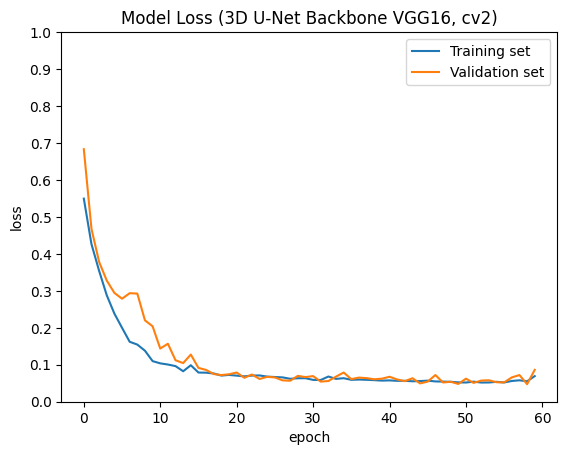

In [22]:
# Plot model loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Model Loss (3D U-Net Backbone VGG16, cv2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/3DPart/3D/3DUNetModel/vgg16_3D_cv9.h5')